In [2]:
import torch
#from data import *
import scipy
from scipy.stats import norm
import matplotlib.pyplot as plt
from torch.optim import Adagrad
from torch.optim import Adam
from tqdm import tqdm
#from vae import *
#import argparse

import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.gridspec as gridspec


In [123]:
HIDDEN=32
BATCH_SIZE=64
EPOCHS=50
LR=2e-3
LATENT=32


#specify the device
device="cuda:0"

In [124]:
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim=2):
        """
            @param input_dim: input dimension of the data
            @param hidden_dim: hidden dimension of the MLPs
            @param latent_dim: output dimension of MLPs
            @------------------@
            @return: None
        """
        super(VAE,self).__init__()
        self.en = nn.Sequential(
            nn.Linear(input_dim,hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.LeakyReLU()
        )
        self.mu = nn.Linear(hidden_dim, latent_dim)
        self.var = nn.Linear(hidden_dim,latent_dim)
        
        self.de = nn.Sequential(
            nn.Linear(latent_dim,hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.LeakyReLU()
        )

        self.final_layer=nn.Sequential(
            nn.Linear(hidden_dim,input_dim),
        )

        
          
    def encode(self,x):
        #x = torch.flatten(x)
        res = self.en(x)
        mu = self.mu(res)
        log_var = self.var(res)
        
        return mu,log_var
            
    def decode(self,x):
        res = self.de(x)
        res = self.final_layer(res)
        return res
    def reparameterize(self,mu,log_var):
        epsilon = torch.normal(mu,torch.exp(0.5 * log_var))
        return mu + log_var * epsilon
    def forward(self,x):
        mu, log_var = self.encode(x)
        norm = self.reparameterize(mu,log_var)
        res = self.decode(norm)
        return (res, x, mu,log_var)



    def loss_fc(self,x,label,*args):
        (res, x, mu, log_var) = self.forward(x)
        recon_loss = F.mse_loss(res,label)
        KL_divergence = torch.mean(-0.5 * torch.sum((1 + log_var - mu**2 - torch.exp(log_var)),dim=1), dim=0)
        KL_divergence.required_grad = True
        loss = recon_loss + KL_divergence
        
        return dict({'loss': loss, 'recon_loss': recon_loss, 'kl_loss': KL_divergence})



    def generate(self,x):
        return self.forward(x)[0]


In [125]:
from scipy.io import loadmat

def get_minibatch(x,batch_size,device='cpu'):
    indices = torch.randperm(x.shape[0])[:batch_size]
    return x[indices].reshape(batch_size, -1).to(device)
def get_data(path, noise=None,nums=25000):
    img_data = scipy.io.loadmat(path)["data"].T / 255.
    img_data = torch.Tensor(img_data)
    img_data = get_minibatch(img_data,nums)
    img_data = img_data.to(device)
    distri = torch.zeros(img_data.shape)
    
    print(f"Shape of a data point: {img_data.shape}")
    print(f"Example data {img_data[0:1].shape}")
    return img_data

def add_noise(data, std=1/10.,device='cpu'):
    distri = torch.normal(torch.zeros(data.shape),torch.ones(data.shape) * std).to(device)
    return data + distri
    #print(distri)

Shape of a data point: torch.Size([25000, 784])
Example data torch.Size([1, 784])


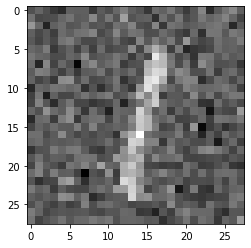

In [138]:
x = get_data("../Data/mnist.mat", noise=True)
t = add_noise(x,std=1/4.,device=device).cpu().detach().numpy()
plt.imshow(t[0].reshape(28,28),cmap="gray")

In [139]:
def AEVB(data, model, optimizer, input_dim, output_dim,epochs, batch_size):
    full_loss, kld, recon = [],[],[]
    for epc in range(epochs):
        fl,kl,rec = 0,0,0
        steps = x.shape[0] // batch_size
        for _ in tqdm(range(steps)):
            batch = get_minibatch(x,batch_size,device)
            batch_noise = add_noise(batch, std=1/45., device=device)
            optimizer.zero_grad()
 
            losses = model.loss_fc(batch_noise,batch)
        
            fl += losses["loss"].item() / batch_size
            kl += losses["kl_loss"].item() / batch_size
            rec += losses["recon_loss"].item() / batch_size
        
            losses["loss"].backward()

            optimizer.step()
        fl /= steps; kl /= steps; rec /= steps
        full_loss.append(fl); kld.append(kl); recon.append(rec)
        print(f"Epoch {epc + 1}\tFull loss: {full_loss[-1]}\trecon loss: {recon[-1]}\tkl_divergence: {kld[-1]}")
        
    return model, full_loss, kld, recon 





In [140]:
#Model 
model = VAE(x.shape[1],HIDDEN,LATENT).to(device)
# Optimizer

optimizer = Adam(model.parameters(), lr=LR)

In [141]:
(model, full_loss, kld, recon) = AEVB(data=x,
                                      model=model,
                                      optimizer=optimizer,
                                      input_dim=x.shape[1],
                                      output_dim=x.shape[1],
                                      batch_size=BATCH_SIZE,
                                      epochs=EPOCHS)

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:02<00:00, 172.46it/s]


Epoch 1	Full loss: 0.045368593008233565	recon loss: 0.001119242728693793	kl_divergence: 0.04424934999671024


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:02<00:00, 162.31it/s]


Epoch 2	Full loss: 0.004486079127169572	recon loss: 0.0008266218603612521	kl_divergence: 0.0036594572662113187


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:02<00:00, 151.80it/s]


Epoch 3	Full loss: 0.003407864494679066	recon loss: 0.000753208277717185	kl_divergence: 0.0026546562183051344


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:02<00:00, 160.37it/s]


Epoch 4	Full loss: 0.002800365435317732	recon loss: 0.0007008549194627752	kl_divergence: 0.002099510513019199


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:02<00:00, 158.90it/s]


Epoch 5	Full loss: 0.0023397772026678117	recon loss: 0.0006471120141960012	kl_divergence: 0.0016926651871285569


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:02<00:00, 157.71it/s]


Epoch 6	Full loss: 0.001874075989680699	recon loss: 0.0005944090629689013	kl_divergence: 0.0012796669299953067


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:02<00:00, 165.52it/s]


Epoch 7	Full loss: 0.0015164391964506835	recon loss: 0.0005485160333008911	kl_divergence: 0.0009679231631497924


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:02<00:00, 164.24it/s]


Epoch 8	Full loss: 0.0011198645920301668	recon loss: 0.0005050526860987959	kl_divergence: 0.0006148119092148801


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:02<00:00, 161.08it/s]


Epoch 9	Full loss: 0.0009048833968476034	recon loss: 0.00047608730868281177	kl_divergence: 0.00042879608831404207


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:02<00:00, 151.66it/s]


Epoch 10	Full loss: 0.000691988920339216	recon loss: 0.00043602066110067357	kl_divergence: 0.0002559682602273264


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:02<00:00, 144.29it/s]


Epoch 11	Full loss: 0.0005867970161116085	recon loss: 0.00041459079045288934	kl_divergence: 0.00017220622670347205


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:02<00:00, 172.60it/s]


Epoch 12	Full loss: 0.0005019950283428606	recon loss: 0.0003909633292679269	kl_divergence: 0.00011103169834733798


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:02<00:00, 171.63it/s]


Epoch 13	Full loss: 0.0004605776775861159	recon loss: 0.00037015270059689495	kl_divergence: 9.042497624296886e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:02<00:00, 164.61it/s]


Epoch 14	Full loss: 0.000422620703615487	recon loss: 0.0003482674584329988	kl_divergence: 7.435324546233274e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:02<00:00, 165.88it/s]


Epoch 15	Full loss: 0.0003987378087820103	recon loss: 0.0003338256530696526	kl_divergence: 6.49121556190762e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:02<00:00, 164.23it/s]


Epoch 16	Full loss: 0.00037359517293038947	recon loss: 0.0003182420120514834	kl_divergence: 5.535316087890607e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:02<00:00, 172.56it/s]


Epoch 17	Full loss: 0.0003406940722085822	recon loss: 0.0002956909496181955	kl_divergence: 4.500312262769932e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:02<00:00, 173.75it/s]


Epoch 18	Full loss: 0.0003136043089071814	recon loss: 0.0002746451965485437	kl_divergence: 3.89591132541402e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:02<00:00, 174.71it/s]


Epoch 19	Full loss: 0.00028400415769563273	recon loss: 0.0002510095168896115	kl_divergence: 3.299464026498847e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:02<00:00, 173.35it/s]


Epoch 20	Full loss: 0.0002596718275946422	recon loss: 0.00023001386020601226	kl_divergence: 2.9657968022944166e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:02<00:00, 170.09it/s]


Epoch 21	Full loss: 0.0002445057371052173	recon loss: 0.00021442638378805267	kl_divergence: 3.0079353018663822e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:02<00:00, 166.21it/s]


Epoch 22	Full loss: 0.00022913895693655388	recon loss: 0.00020069447536325943	kl_divergence: 2.8444481778513782e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:02<00:00, 147.04it/s]


Epoch 23	Full loss: 0.0002171276746174464	recon loss: 0.00018903907736948428	kl_divergence: 2.8088596856179768e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:02<00:00, 168.23it/s]


Epoch 24	Full loss: 0.0002114820712356446	recon loss: 0.0001821147130939584	kl_divergence: 2.9367358160342494e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:02<00:00, 170.66it/s]


Epoch 25	Full loss: 0.0002050298925426502	recon loss: 0.00017447363218077674	kl_divergence: 3.055626043649868e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:02<00:00, 164.17it/s]


Epoch 26	Full loss: 0.00020188309609716853	recon loss: 0.00016990471922326834	kl_divergence: 3.19783768365876e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:02<00:00, 168.89it/s]


Epoch 27	Full loss: 0.00019918194395872072	recon loss: 0.0001659867007476397	kl_divergence: 3.319524330436252e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:02<00:00, 168.74it/s]


Epoch 28	Full loss: 0.00019536629790822282	recon loss: 0.0001616329567742725	kl_divergence: 3.373334132051334e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:02<00:00, 164.41it/s]


Epoch 29	Full loss: 0.00019213376739898172	recon loss: 0.00015784413083635556	kl_divergence: 3.428963671187655e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:02<00:00, 158.56it/s]


Epoch 30	Full loss: 0.0001898504412309147	recon loss: 0.00015494294982487097	kl_divergence: 3.4907491573950466e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:02<00:00, 176.37it/s]


Epoch 31	Full loss: 0.00018408874472161421	recon loss: 0.00015049090068667935	kl_divergence: 3.359784371777772e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:02<00:00, 161.48it/s]


Epoch 32	Full loss: 0.00017958994602593475	recon loss: 0.00014672504573051508	kl_divergence: 3.2864900332732266e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:02<00:00, 166.33it/s]


Epoch 33	Full loss: 0.0001740049953253056	recon loss: 0.00014256655638933015	kl_divergence: 3.143843884269397e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:02<00:00, 164.48it/s]


Epoch 34	Full loss: 0.00017034048621262162	recon loss: 0.0001398872775145066	kl_divergence: 3.0453208306332667e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:02<00:00, 169.98it/s]


Epoch 35	Full loss: 0.00016612428843449707	recon loss: 0.0001368967806532358	kl_divergence: 2.922750761335453e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:02<00:00, 163.82it/s]


Epoch 36	Full loss: 0.0001627013666364245	recon loss: 0.00013446404101649442	kl_divergence: 2.823732565724267e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:02<00:00, 160.40it/s]


Epoch 37	Full loss: 0.00015749871560658972	recon loss: 0.0001307049699579903	kl_divergence: 2.6793745741880953e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:02<00:00, 165.17it/s]


Epoch 38	Full loss: 0.00015307429428689946	recon loss: 0.00012761820829697312	kl_divergence: 2.5456085691425518e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:02<00:00, 170.26it/s]


Epoch 39	Full loss: 0.00015194411158191566	recon loss: 0.00012687305650802163	kl_divergence: 2.5071055596270478e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:02<00:00, 159.12it/s]


Epoch 40	Full loss: 0.00014590236465804852	recon loss: 0.00012210850745293265	kl_divergence: 2.379385698124026e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:02<00:00, 165.37it/s]


Epoch 41	Full loss: 0.00014591084099941864	recon loss: 0.0001228202291456863	kl_divergence: 2.309061194701383e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:02<00:00, 156.03it/s]


Epoch 42	Full loss: 0.0001406687496152396	recon loss: 0.00011854568688133254	kl_divergence: 2.212306280853227e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:02<00:00, 152.83it/s]


Epoch 43	Full loss: 0.00013890446869668384	recon loss: 0.00011735518538700537	kl_divergence: 2.154928345892889e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:02<00:00, 160.73it/s]


Epoch 44	Full loss: 0.0001353562969411425	recon loss: 0.00011439508286854013	kl_divergence: 2.096121341963179e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:02<00:00, 149.38it/s]


Epoch 45	Full loss: 0.00013586194806684476	recon loss: 0.00011488859068217257	kl_divergence: 2.0973357254078087e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:02<00:00, 157.13it/s]


Epoch 46	Full loss: 0.00012979874826179674	recon loss: 0.00010998174994034717	kl_divergence: 1.9816998209511765e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:02<00:00, 162.83it/s]


Epoch 47	Full loss: 0.00012840277055287377	recon loss: 0.0001087676182438512	kl_divergence: 1.963515212245954e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:02<00:00, 165.40it/s]


Epoch 48	Full loss: 0.00012885901438167843	recon loss: 0.00010956437270998811	kl_divergence: 1.9294641391845802e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:02<00:00, 164.62it/s]


Epoch 49	Full loss: 0.00012798096420458304	recon loss: 0.00010863879858963908	kl_divergence: 1.9342165391068332e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:02<00:00, 167.03it/s]

Epoch 50	Full loss: 0.00012855381363083442	recon loss: 0.00010911406580140838	kl_divergence: 1.9439748202552064e-05


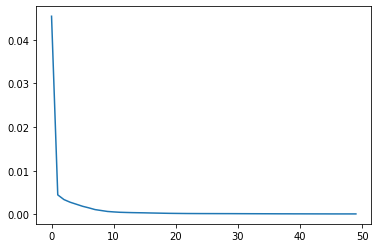

In [142]:
%matplotlib inline

plt.plot([i for i in range(len(full_loss))], full_loss)

In [155]:
def visualization(x):
    kx = get_minibatch(x,25,device)
    kx = add_noise(kx, std=1, device=device)
    gen = model.generate(kx).cpu().detach().numpy()
    kx = kx.cpu().detach().numpy()
    

    fig, ax = plt.subplots(5,5)
    for i in range(1,6):
        for j in range(1,6):
            ax[i-1,j-1].axis("off")
            tmp = kx[i*j - 1]
            tmp = tmp.reshape(28,28)
            ax[i - 1,j - 1].imshow(tmp,cmap="gray")
    
    
    
    
    fig2, ax2 = plt.subplots(5,5)
    for i in range(1,6):
        for j in range(1,6):
            ax2[i-1,j-1].axis("off")
            tmp = gen[i*j - 1]
            tmp = tmp.reshape(28,28)
            ax2[i - 1,j - 1].imshow(tmp,cmap="gray")
    fig.show()
    fig2.show()

In [157]:
visualization(x)

TypeError: linear(): argument 'input' (position 1) must be Tensor, not numpy.ndarray